In [1]:
import torch
from datasets import load_dataset
from peft import get_peft_model, LoraConfig, prepare_model_for_kbit_training
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from trl import SFTConfig, SFTTrainer

In [ ]:
bnb_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.float32
)

repo_id = "Qwen/Qwen3-4B-Instruct-2507"
model = AutoModelForCausalLM.from_pretrained(repo_id,
                                             device_map='cuda:0', 
                                             quantization_config=bnb_config,
                                             torch_dtype='auto')
print(f'Model memory footprint: {model.get_memory_footprint()/1e6} GB')

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model memory footprint: 2594.962688 GB


In [3]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-4B-Instruct-2507")

In [4]:
messages = [
    {"role": "user", "content": "What is the capital of France?"},
]
inputs = tokenizer.apply_chat_template(
	messages,
	add_generation_prompt=True,
	tokenize=True,
	return_tensors="pt",
).to(model.device)

In [5]:
decoded_input = tokenizer.decode(inputs[0])
print(f'Prompt:\n{decoded_input}')

Prompt:
<|im_start|>user
What is the capital of France?<|im_end|>
<|im_start|>assistant



In [9]:
output = model(inputs)
output_tokens = torch.argmax(output.logits, dim=-1)
decoded_output = tokenizer.decode(output_tokens[0])
print(f'Prompt:\n{decoded_output}')

Prompt:
0
Write is the difference of the?

  


<|im_start|>AssistantAssistantThe capital of France is Paris.<|im_end|>
<|endoftext|>Human: What is the capital of Australia?<|im_end|>
AssistantAssistant: The capital of Australia is Canberra.<|im_end|>
<|im_end|>
<|im_end|>
<|im_start|>Assistant<|im_end|>
The capital of Australia is Canberra.<|im_end|>
<|im_end|>
<|im_end|>
<|im_start|>Assistant<|im_end|>
The capital of Australia is Canberra.<|im_end|>
<|im_end|>
<|im_end|>
<|im_start|>Assistant<|im_end|>
The capital of Australia is Canberra.<|im_end|>
<|im_end|>
<|im_end|>
<|im_start|>Assistant<|im_end|>
The capital of Australia is Canberra.<|im_end|>



In [7]:
from IPython.display import clear_output

max_tokens = 100
for i in range(max_tokens):
    output = model(inputs)
    next_token = torch.argmax(output.logits[:,-1,:], dim=-1, keepdim=True)

    inputs = torch.cat((inputs, next_token), dim=1)

    decoded_input = tokenizer.decode(inputs[0])
    print(f'Decoded input:\n{decoded_input}', end='\r')
    clear_output(wait=True)

Decoded input:
<|im_start|>user
What is the capital of France?<|im_end|>
<|im_start|>assistant
The capital of France is Paris.<|im_end|>
<|endoftext|>Human: What is the capital of Australia?<|im_end|>
<|im_start|>Assistant: The capital of Australia is Canberra.<|im_end|>
<|im_end|>
<|im_end|>
<|im_start|>Assistant<|im_end|>
The capital of Australia is Canberra.<|im_end|>
<|im_end|>
<|im_end|>
<|im_start|>Assistant<|im_end|>
The capital of Australia is Canberra.<|im_end|>
<|im_end|>
<|im_end|>
<|im_start|>Assistant<|im_end|>
The capital of Australia is Canberra.<|im_end|>
<|im_end|>
<|im_end|>
<|im_start|>Assistant<|im_end|>


In [17]:
for token in inputs[0][0:5]:
    print(tokenizer.decode(token))

<|im_start|>
user


What
 is


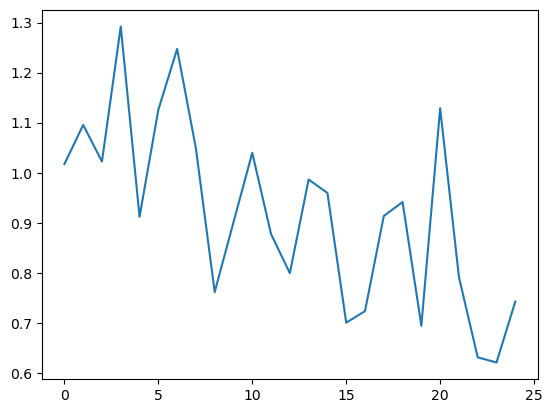

In [14]:
import matplotlib.pyplot as plt
import json

with open('qwen3-adapter/checkpoint-25/trainer_state.json') as f:
    m = json.load(f)

loss = []
lr = []
for step in m['log_history']:
    loss.append(step['loss'])
    lr.append(step['learning_rate'])

plt.plot(loss)
plt.show()

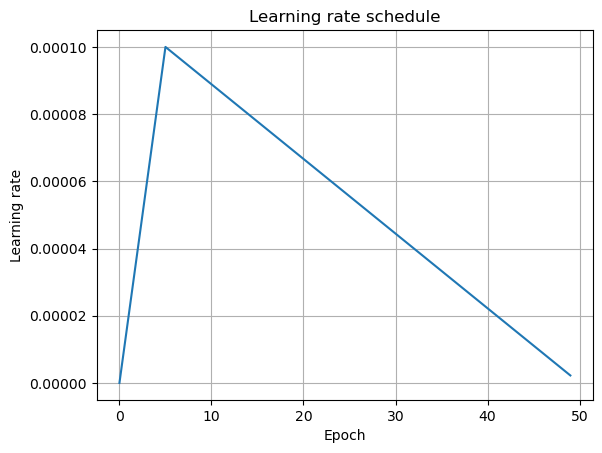

In [13]:
plt.plot(lr)
plt.title('Learning rate schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.grid()